In [1]:
!pip install transformers
!pip install -U sentence-transformers
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.1 MB/s eta 0:00:00


In [2]:
from sentence_transformers import SentenceTransformer

from transformers import AutoTokenizer, AutoModel, AutoConfig
from torch.nn.functional import normalize
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
import torch

import faiss

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests

In [3]:
def get_raw_data():
    train_data_url = "https://storage.googleapis.com/indianlegalbert/OPEN_SOURCED_FILES/Rhetorical_Role_Benchmark/Data/train.json"
    test_data_url = "https://storage.googleapis.com/indianlegalbert/OPEN_SOURCED_FILES/Rhetorical_Role_Benchmark/Data/dev.json"
    train_data_json = requests.get(train_data_url).json()
    test_data_json = requests.get(test_data_url).json()
    return train_data_json, test_data_json

CLASSES = ['PREAMBLE', 'NONE', 'FAC', 'ARG_RESPONDENT', 'RLC', 'ARG_PETITIONER', 'ANALYSIS', 'PRE_RELIED', 'RATIO', 'RPC', 'ISSUE', 'STA', 'PRE_NOT_RELIED']
train_data_json, test_data_json = get_raw_data()

In [4]:
train_labels_all=[]
train_data=[]

for item in train_data_json:
  for annotations in item['annotations']:
    for results in annotations['result']:
      train_data.append(results['value']['text'].strip())
      train_labels_all.append(results['value']['labels'][0])

test_labels_all=[]
test_data =[]

for item in test_data_json:
  for annotations in item['annotations']:
    for results in annotations['result']:
      test_data.append(results['value']['text'].strip())
      test_labels_all.append(results['value']['labels'][0])

TRAINING_SIZE = len(train_labels_all)

In [5]:
model = SentenceTransformer('sentence-transformers/paraphrase-xlm-r-multilingual-v1')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.78k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
def get_embeddings(sentence):
  return model.encode(sentence)

In [7]:
X = []
y = []
train_labels_unique = list(set(train_labels_all))
progress = 0
for sentence, label in zip(train_data[:TRAINING_SIZE], train_labels_all[:TRAINING_SIZE]):
    X.append(get_embeddings(sentence))
    y.append(train_labels_unique.index(label))
    progress += 1
    if progress % 500 == 0:
        print(f'Progress: {100 * progress / TRAINING_SIZE}%')


Progress: 1.7249706754985166%
Progress: 3.449941350997033%
Progress: 5.17491202649555%
Progress: 6.899882701994066%
Progress: 8.624853377492583%
Progress: 10.3498240529911%
Progress: 12.074794728489616%
Progress: 13.799765403988133%
Progress: 15.52473607948665%
Progress: 17.249706754985166%
Progress: 18.97467743048368%
Progress: 20.6996481059822%
Progress: 22.424618781480714%
Progress: 24.149589456979232%
Progress: 25.874560132477747%
Progress: 27.599530807976265%
Progress: 29.32450148347478%
Progress: 31.0494721589733%
Progress: 32.77444283447181%
Progress: 34.49941350997033%
Progress: 36.22438418546885%
Progress: 37.94935486096736%
Progress: 39.67432553646588%
Progress: 41.3992962119644%
Progress: 43.124266887462916%
Progress: 44.84923756296143%
Progress: 46.574208238459946%
Progress: 48.299178913958464%
Progress: 50.02414958945698%
Progress: 51.749120264955494%
Progress: 53.47409094045401%
Progress: 55.19906161595253%
Progress: 56.92403229145105%
Progress: 58.64900296694956%
Progres

In [8]:
X = np.array(X)
y = np.array(y)

In [20]:
index = faiss.IndexIVFFlat(faiss.IndexFlatL2(X.shape[1]), X.shape[1], len(train_labels_unique), faiss.METRIC_L2)
index.train(X)
index.add(X)

In [21]:
test_embeddings = []
for i in test_data:
  test_embeddings.append(get_embeddings(i))

test_embeddings = np.array(test_embeddings)

In [22]:
_, indices = index.search(test_embeddings, 1)
preds=[train_labels_unique[y[i[0]]] for i in indices]

In [23]:
match_count=0
all=0
for i,j in zip(test_labels_all, preds):
  if i==j:
    match_count+=1
  all+=1

f1score = f1_score(test_labels_all, preds, average="macro")

print("F1 Score:", f1score)
print("Precision:", match_count/all)

F1 Score: 0.3329157145830798
Precision: 0.4598615916955017


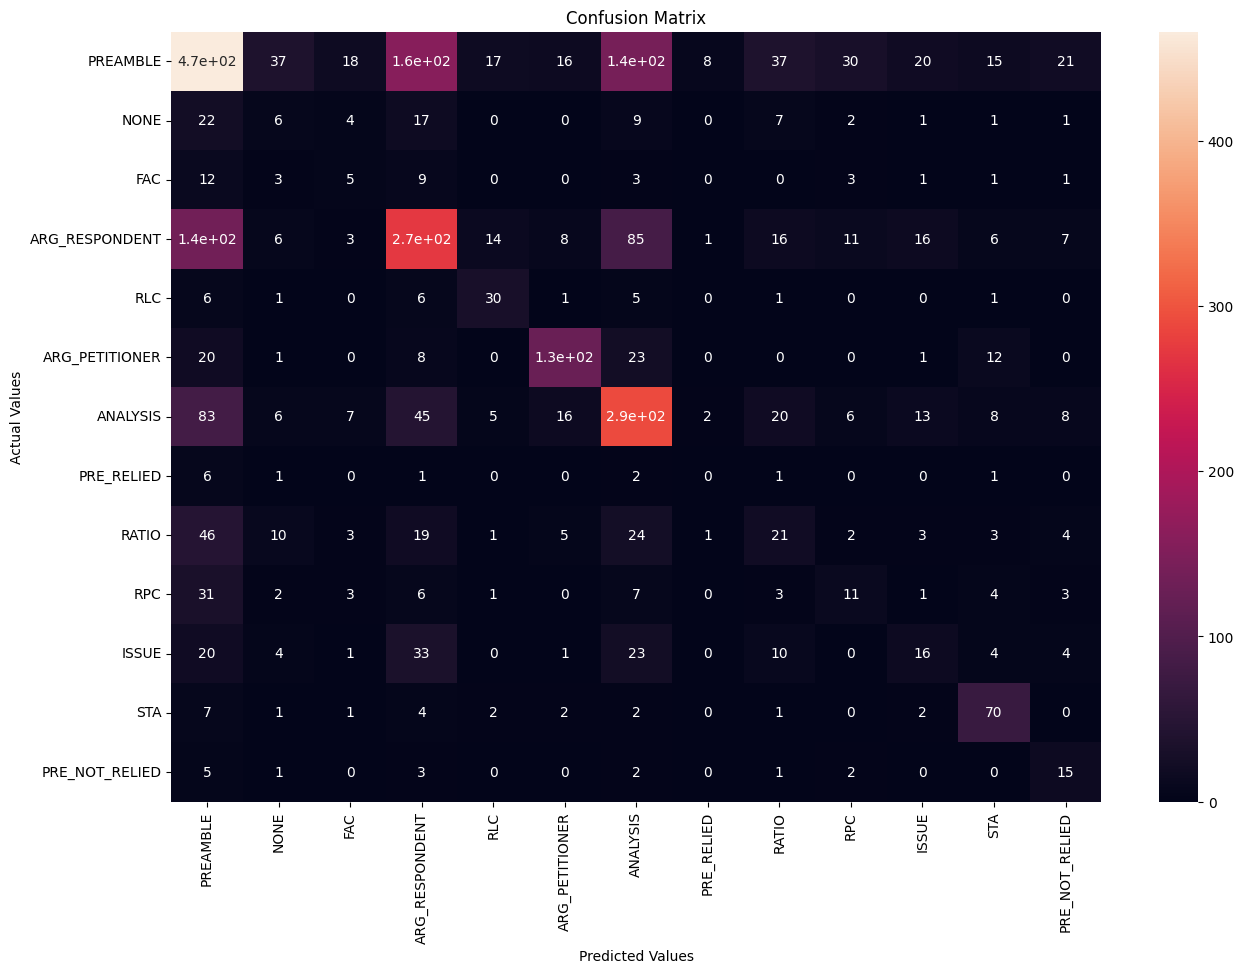

In [24]:
cm = confusion_matrix(test_labels_all, preds)
cm_df = pd.DataFrame(cm, index = CLASSES, columns = CLASSES)

plt.figure(figsize=(15,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()